In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# import logging
# logger = logging.getLogger('fbprophet')
# logger.setLevel(logging.CRITICAL)
# logger = logging.getLogger('matplotlib')
# logger.setLevel(logging.CRITICAL)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
df = pd.read_csv('../data/kaggle_energy/train_bid_1249.csv')
df_w = pd.read_csv('../data/kaggle_energy/weather_train_sid_14.csv')

df['timestamp'] = pd.to_datetime(df['timestamp'])
df_w['timestamp'] = pd.to_datetime(df_w['timestamp'])

In [4]:
df = df.merge(df_w)
df

,building_id,meter,timestamp,meter_reading,site_id,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,1249,1,2016-01-01 01:00:00,830.408,14,5.6,0.0,-0.6,0.0,1019.3,300.0,2.6
1,1249,1,2016-01-01 02:00:00,646.394,14,5.6,4.0,-0.6,0.0,1019.4,300.0,2.6
2,1249,1,2016-01-01 03:00:00,662.382,14,5.6,NaN,-1.1,0.0,1019.4,NaN,1.5
3,1249,1,2016-01-01 04:00:00,672.578,14,5.0,NaN,-2.2,0.0,1019.2,290.0,3.1
4,1249,1,2016-01-01 05:00:00,576.014,14,4.4,NaN,-2.2,0.0,1018.9,300.0,4.1
...,...,...,...,...,...,...,...,...,...,...,...,...
8772,1249,1,2016-12-31 19:00:00,743.702,14,6.7,0.0,-8.3,0.0,1015.8,200.0,6.7
8773,1249,1,2016-12-31 20:00:00,663.586,14,5.6,4.0,-6.7,0.0,1015.3,200.0,5.7
8774,1249,1,2016-12-31 21:00:00,843.705,14,5.6,NaN,-6.7,0.0,1014.9,190.0,5.7
8775,1249,1,2016-12-31 22:00:00,653.339,14,5.6,NaN,-6.7,0.0,1014.0,190.0,6.7


In [5]:
df[df[['meter_reading', 'air_temperature']].isna().any(axis=1)]

,building_id,meter,timestamp,meter_reading,site_id,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
3916,1249,1,2016-06-12 05:00:00,2078.74,14,NaN,NaN,NaN,0.0,NaN,NaN,NaN


In [6]:
df = df.dropna(subset=['meter_reading', 'air_temperature'])

In [7]:
len(df)

8776

In [8]:
# rename columns
df = df.rename(columns={'timestamp': 'ds', 'meter_reading': 'y'})

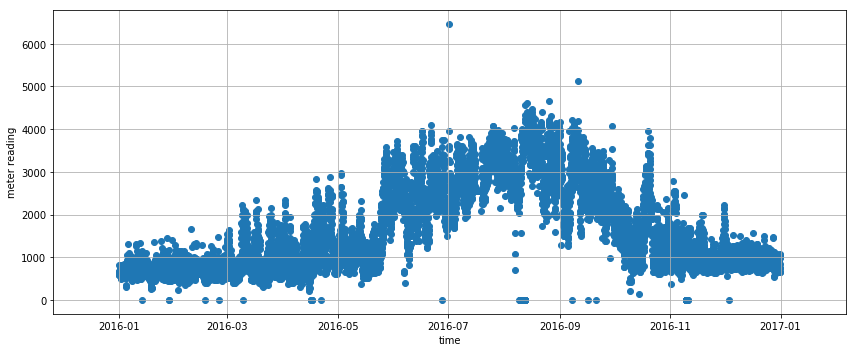

In [9]:
fig, axes = plt.subplots(figsize=(12, 5))

plt.scatter(df['ds'].to_numpy(), df['y'].to_numpy())
plt.xlabel('time')
plt.ylabel('meter reading')
plt.grid(True)
plt.tight_layout()
plt.show()

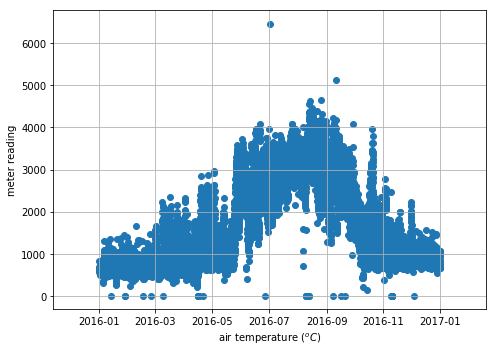

In [10]:
fig, ax = plt.subplots(figsize=(7, 5))
plt.scatter(df['ds'].to_numpy(), df['y'].to_numpy())
plt.xlabel('air temperature ($^oC$)')
plt.ylabel('meter reading')
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
df_daily = df.set_index('ds').resample('D').sum().reset_index()

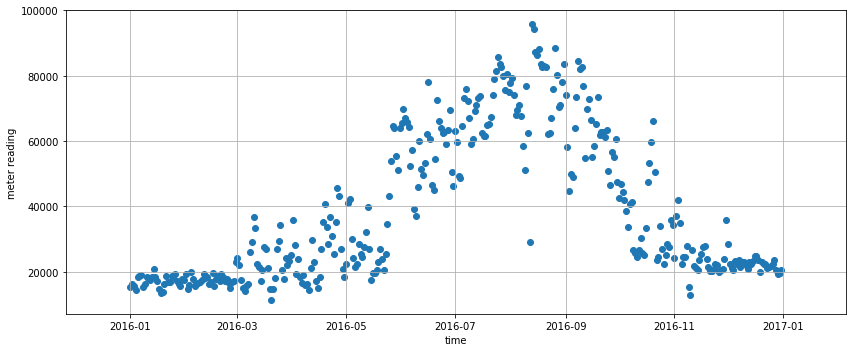

In [12]:
fig, ax = plt.subplots(figsize=(12, 5))
plt.scatter(df_daily['ds'].to_numpy(), df_daily['y'].to_numpy())
plt.xlabel('time')
plt.ylabel('meter reading')
plt.grid(True)
plt.tight_layout()
plt.show()

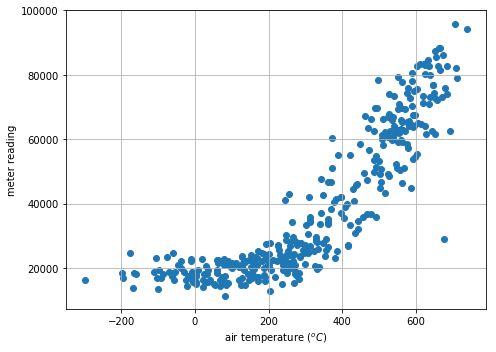

In [13]:
fig, ax = plt.subplots(figsize=(7, 5))
plt.scatter(df_daily['air_temperature'].to_numpy(), df_daily['y'].to_numpy())
plt.xlabel('air temperature ($^oC$)')
plt.ylabel('meter reading')
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
t = pd.Timestamp('2016-11-1')  # 10 months training vs. 2 months testing
df_train = df[df['ds'] < t]
df_test = df[df['ds'] >= t]

In [15]:
df_test.head()

,building_id,meter,ds,y,site_id,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
7313,1249,1,2016-11-01 00:00:00,1109.580,14,8.3,0.0,0.6,0.0,1023.3,360.0,1.5
7314,1249,1,2016-11-01 01:00:00,684.994,14,6.7,0.0,0.6,0.0,1023.8,350.0,2.1
7315,1249,1,2016-11-01 02:00:00,738.203,14,6.1,0.0,0.6,0.0,1024.4,340.0,2.6
7316,1249,1,2016-11-01 03:00:00,923.034,14,5.6,0.0,0.0,0.0,1024.8,340.0,2.6
7317,1249,1,2016-11-01 04:00:00,835.721,14,4.4,0.0,-0.6,0.0,1025.3,340.0,2.1


# Train Prophet

In [16]:
from fbprophet import Prophet

In [17]:
m = Prophet()
m.fit(df_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [18]:
future = m.make_future_dataframe(periods=24*30 + 24*31, freq='H')
future.tail()

,ds
8771,2016-12-31 19:00:00
8772,2016-12-31 20:00:00
8773,2016-12-31 21:00:00
8774,2016-12-31 22:00:00
8775,2016-12-31 23:00:00


In [19]:
forecast = m.predict(future)

In [20]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
8771,2016-12-31 19:00:00,-818.804258,-1492.059178,527.104383,-1575.669068,-51.966163,304.392324,304.392324,304.392324,342.005502,342.005502,342.005502,-37.613178,-37.613178,-37.613178,0.0,0.0,0.0,-514.411933
8772,2016-12-31 20:00:00,-820.118076,-1546.927395,482.483683,-1577.460794,-52.641323,307.536790,307.536790,307.536790,350.055952,350.055952,350.055952,-42.519161,-42.519161,-42.519161,0.0,0.0,0.0,-512.581285
8773,2016-12-31 21:00:00,-821.431893,-1544.282824,398.583036,-1579.252520,-53.316482,271.235829,271.235829,271.235829,318.857844,318.857844,318.857844,-47.622015,-47.622015,-47.622015,0.0,0.0,0.0,-550.196064
8774,2016-12-31 22:00:00,-822.745711,-1704.166740,449.690090,-1581.044246,-53.991642,197.113112,197.113112,197.113112,250.009893,250.009893,250.009893,-52.896781,-52.896781,-52.896781,0.0,0.0,0.0,-625.632599
8775,2016-12-31 23:00:00,-824.059529,-1725.959340,180.796815,-1582.835972,-54.666801,106.300960,106.300960,106.300960,164.616586,164.616586,164.616586,-58.315626,-58.315626,-58.315626,0.0,0.0,0.0,-717.758570


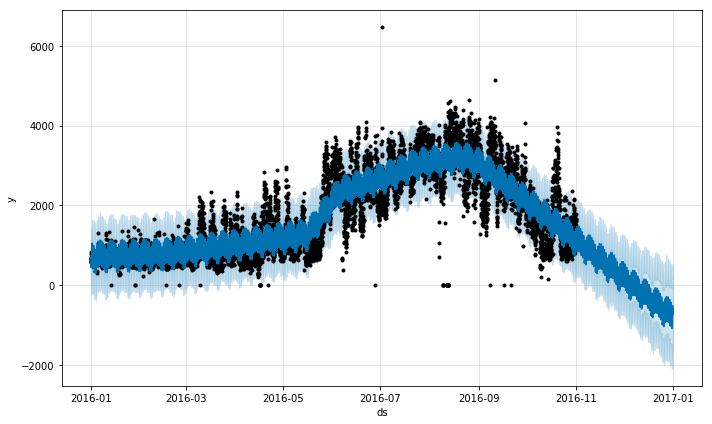

In [21]:
fig = m.plot(forecast)

# Add regressor

In [22]:
m = Prophet()
m.add_regressor('air_temperature')
m.fit(df_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


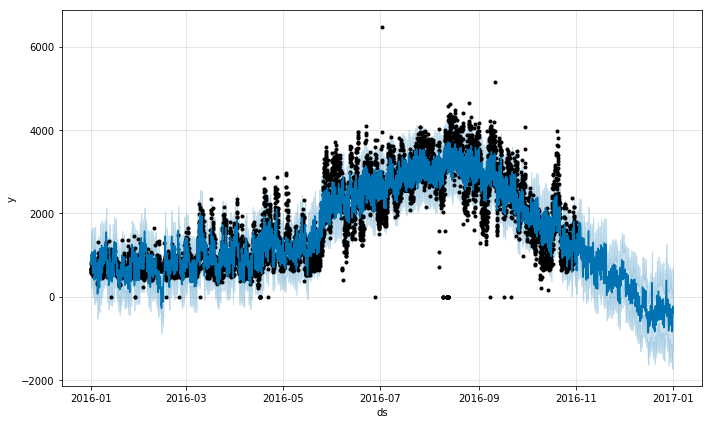

In [23]:
future = m.make_future_dataframe(periods=24*30 + 24*31, freq='H')
future['air_temperature'] = df['air_temperature']
future[['air_temperature']] = future[['air_temperature']].fillna(method='ffill') # not sure why it compains 
forecast = m.predict(future)
fig = m.plot(forecast)

# Daily

In [24]:
t = pd.Timestamp('2016-11-1')  # 10 months training vs. 2 months testing
df_train = df_daily[df_daily['ds'] < t]
df_test = df_daily[df_daily['ds'] >= t]

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


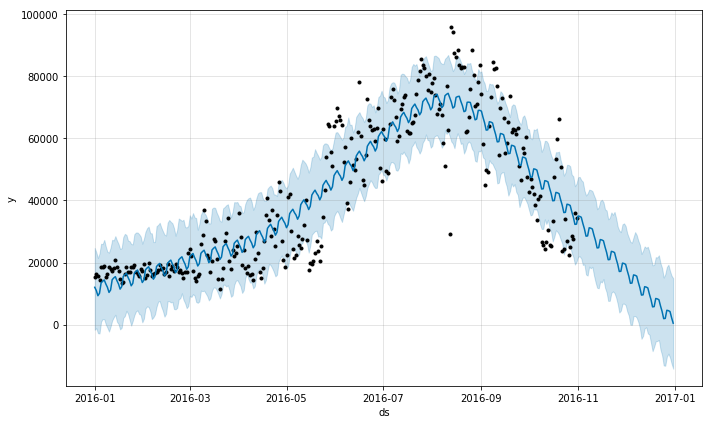

In [25]:
m = Prophet()
m.fit(df_train)

future = m.make_future_dataframe(periods=61)
forecast = m.predict(future)

fig = m.plot(forecast)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


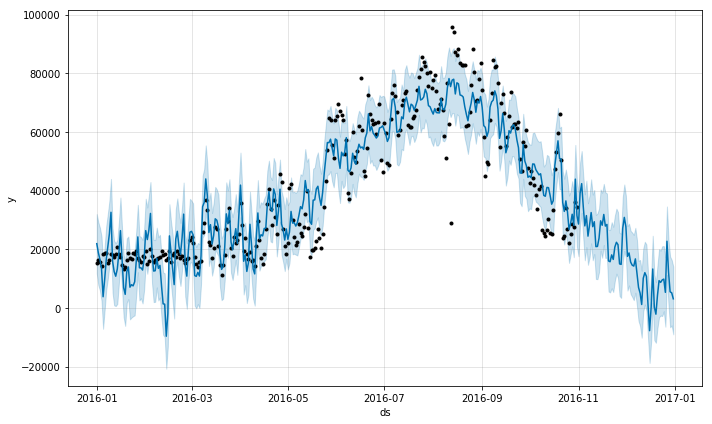

In [26]:
m = Prophet()
m.add_regressor('air_temperature')
m.fit(df_train)

future = m.make_future_dataframe(periods=61)
future['air_temperature'] = df_daily['air_temperature']
forecast = m.predict(future)

fig = m.plot(forecast)

In [27]:
from fbprophet.plot import add_changepoints_to_plot

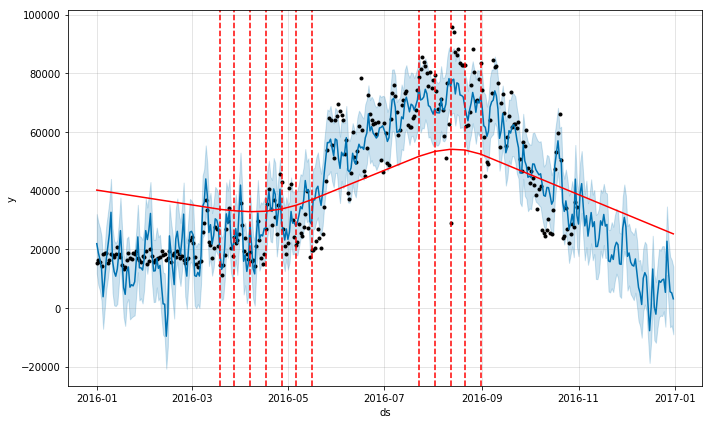

In [28]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)


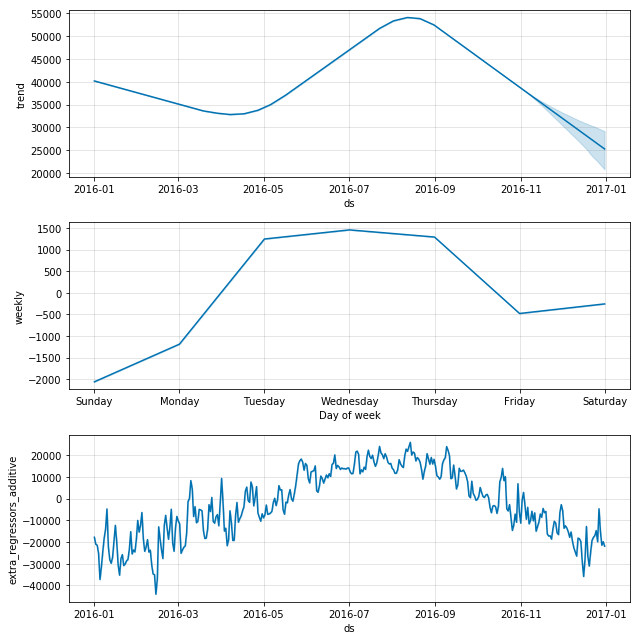

In [29]:
ig = m.plot_components(forecast)